# <font color=orange>ASL-Netz Training</font>
***
***

In [104]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import LearningRateScheduler

RANDOM_SEED = 42

***
## Modellauswahl
### 4a, 4b, 5a, 5b, 6a, 6b, ctrl, A4a

In [105]:
model_version = "4a"
epochs = 60
print("Model:\t" + model_version)

Model:	A4a


***
## <br>Pfadmanagement

In [106]:
if model_version == "ctrl":
    model_folder_file = "controlModel\\control_classifier"
    eval_subfolder = "Control\\"
    NUM_CLASSES = 2
elif model_version == "A4a":
    model_folder_file = "modelA\\ASLclassifier"
    eval_subfolder = "ASL\\"
    NUM_CLASSES = 24
else:
    model_folder_file = "modelB\\ASLclassifier"
    eval_subfolder = "ASL\\"
    NUM_CLASSES = 28

model_save_path = "model\\customModel\\" + model_folder_file + model_version + ".hdf5"
tflite_save_path = "model\\customModel\\" + model_folder_file + model_version + ".tflite"

evaluation_folder = "evaluation\\" + eval_subfolder
confmat_path = evaluation_folder + "confusionMatrix" + model_version + ".png"
classrep_path = evaluation_folder + "classificationReport" + model_version + ".csv"
architecture_path = evaluation_folder + "architecture" + model_version + ".png"
traingraph_path = evaluation_folder + "trainingHistory" + model_version + ".png"

## Modellkonfiguration

In [107]:
match model_version:
    case "4a" | "4b" | "A4a":
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input((61, )),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.Dense(80, activation='relu'),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.Dense(50, activation='relu'),
            tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
        ])
        col_lst = [1] + list(range(5, 65))
        if model_version == "4a":
            csv_file = "keypoints\\keypointB_3D_full.csv"
        elif model_version == "4b":
            csv_file = "keypoints\\keypointB_3D_augmented.csv"
        else:
            csv_file = "keypoints\\keypointA.csv"
            col_lst = list(range(1, 62))
        
    case "5a":
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input((14, )),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.Dense(22, activation='relu'),
            tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
        ])
        col_lst = list([1, 2, 3, 4, 5, 6, 8, 9, 11, 12, 14, 15, 17, 18])
        csv_file = "keypoints\\keypointB_angles_3D.csv"
        
    case "5b":
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input((19, )),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.Dense(24, activation='relu'),
            tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
        ])
        col_lst = list(range(1, 20))
        csv_file = "keypoints\\keypointB_angles_3D.csv"
        
    case "6a":
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input((7, )),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.Dense(22, activation='relu'),
            tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
        ])
        col_lst = list([1, 2, 4, 6, 8, 10, 12])
        csv_file = "keypoints\\keypointB_angles_2D.csv"
        
    case "6b":
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input((13, )),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.Dense(21, activation='relu'),
            tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
        ])
        col_lst = list(range(1, 14))
        csv_file = "keypoints\\keypointB_angles_2D.csv"
        
    case "ctrl":
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input((61, )),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.Dense(40, activation='relu'),
            # tf.keras.layers.Dropout(0.15),
            # tf.keras.layers.Dense(20, activation='relu'),
            tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
        ])
        col_lst = [1] + list(range(5, 65))
        csv_file = "keypoints\\keypointControl_1.csv"
        
    case _:
        model, col_lst, csv_file = [], [], []
        raise ValueError(f"Invalid model version {model_version}")

## Trainingsdaten-Konfiguration

In [108]:
X_dataset = np.loadtxt(csv_file, delimiter=',', dtype='float32', usecols=col_lst)

In [109]:
y_dataset = np.loadtxt(csv_file, delimiter=',', dtype='<U8', usecols=0)

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.8, random_state=RANDOM_SEED)

In [111]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target data to integers
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

## Modellübersicht

In [112]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_10 (Dropout)        (None, 61)                0         
                                                                 
 dense_15 (Dense)            (None, 80)                4960      
                                                                 
 dropout_11 (Dropout)        (None, 80)                0         
                                                                 
 dense_16 (Dense)            (None, 50)                4050      
                                                                 
 dense_17 (Dense)            (None, 24)                1224      
                                                                 
Total params: 10,234
Trainable params: 10,234
Non-trainable params: 0
_________________________________________________________________


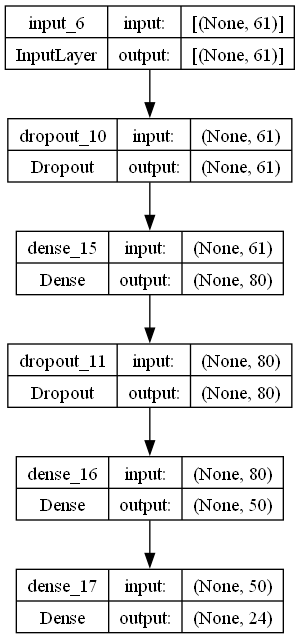

In [113]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Konfiguration des Trainingsablaufs

In [114]:
# cp_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=1, save_weights_only=False)
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

In [115]:
lr_schedule = LearningRateScheduler(lambda epoch: 0.0001 + 0.001 ** (1 + epoch/50))     # 0.0001

In [116]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']    # , 'Precision', 'Recall'
)

## <font color=orange>Training</font>

In [117]:
history = model.fit(
    X_train,
    y_train_encoded,
    epochs=epochs,
    batch_size=128,     # 128
    validation_data=(X_test, y_test_encoded),
    # callbacks=[es_callback]    # callbacks=[cp_callback, es_callback]
    callbacks=[lr_schedule]
)

Epoch 1/1000
35/35 [==============================] - 1s 7ms/step - loss: 3.1408 - accuracy: 0.0723 - val_loss: 2.9836 - val_accuracy: 0.1346 - lr: 0.0010
Epoch 2/1000
35/35 [==============================] - 0s 3ms/step - loss: 2.9239 - accuracy: 0.1422 - val_loss: 2.7868 - val_accuracy: 0.2019 - lr: 8.9096e-04
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 2.7421 - accuracy: 0.1976 - val_loss: 2.5757 - val_accuracy: 0.2981 - lr: 7.7858e-04
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 2.5685 - accuracy: 0.2386 - val_loss: 2.4054 - val_accuracy: 0.2885 - lr: 6.8069e-04
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 2.4316 - accuracy: 0.2843 - val_loss: 2.2218 - val_accuracy: 0.4327 - lr: 5.9544e-04
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 2.3196 - accuracy: 0.3060 - val_loss: 2.0809 - val_accuracy: 0.4904 - lr: 5.2119e-04
Epoch 7/1000
35/35 [==============================

## Evaluation

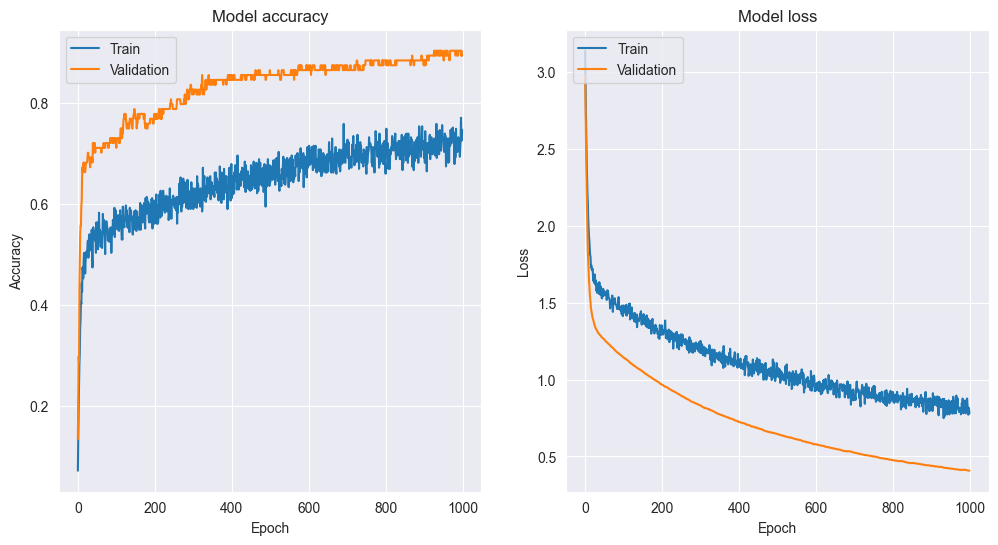

In [118]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

if 1:
    plt.savefig(traingraph_path)

plt.show()

In [119]:
val_loss, val_acc = model.evaluate(X_test, y_test_encoded, batch_size=128)

1/1 [==============================] - 0s 22ms/step - loss: 0.4069 - accuracy: 0.8942


In [120]:
# model = tf.keras.models.load_model(model_save_path)

In [121]:
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 59ms/step
[1.69604778e-01 1.63538717e-02 1.76108740e-02 1.05841341e-03
 3.72294605e-01 8.37027188e-03 4.84983793e-05 1.07866304e-04
 2.45677993e-01 1.29105407e-04 1.45567870e-02 2.64911763e-02
 7.61705963e-03 6.11624634e-03 2.98034070e-10 5.48477308e-09
 1.78932131e-03 1.08239017e-01 7.27365705e-06 9.84204162e-05
 4.06003179e-04 1.60350057e-03 2.95060236e-05 1.78951235e-03]
4


4/4 [==============================] - 0s 2ms/step


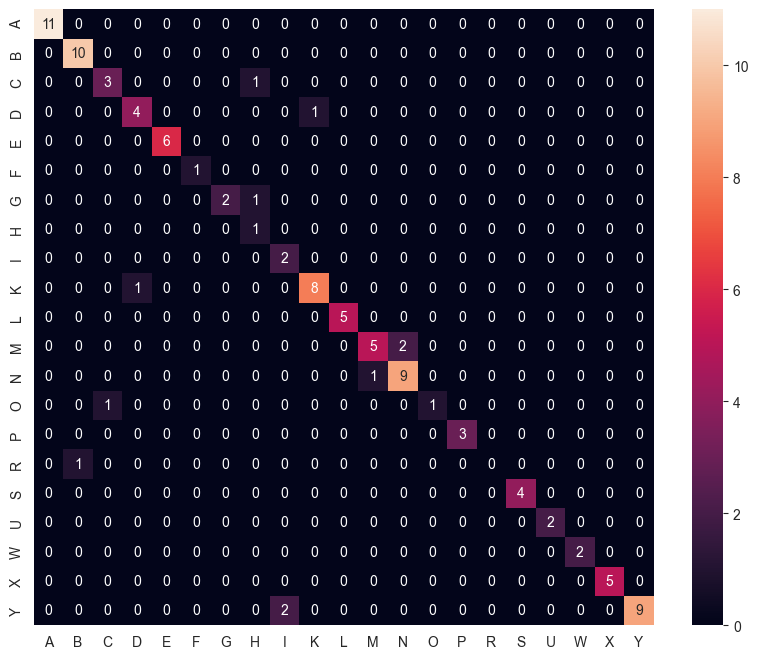

Classification Report
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        11
           B       0.91      1.00      0.95        10
           C       0.75      0.75      0.75         4
           D       0.80      0.80      0.80         5
           E       1.00      1.00      1.00         6
           F       1.00      1.00      1.00         1
           G       1.00      0.67      0.80         3
           H       0.33      1.00      0.50         1
           I       0.50      1.00      0.67         2
           K       0.89      0.89      0.89         9
           L       1.00      1.00      1.00         5
           M       0.83      0.71      0.77         7
           N       0.82      0.90      0.86        10
           O       1.00      0.50      0.67         2
           P       1.00      1.00      1.00         3
           R       0.00      0.00      0.00         1
           S       1.00      1.00      1.00         4
     

D:\Programme\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programme\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programme\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programme\Python\Python310\lib\site-p

In [122]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import plot_model

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(10, 8))  # (7, 6)
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.savefig(confmat_path)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

label_encoder.fit(y_train)
y_test_decoded = label_encoder.inverse_transform(y_test_encoded)
y_pred_decoded = label_encoder.inverse_transform(y_pred)


print_confusion_matrix(y_test_decoded, y_pred_decoded)
classrep_dict = classification_report(y_test_decoded, y_pred_decoded, output_dict=True)

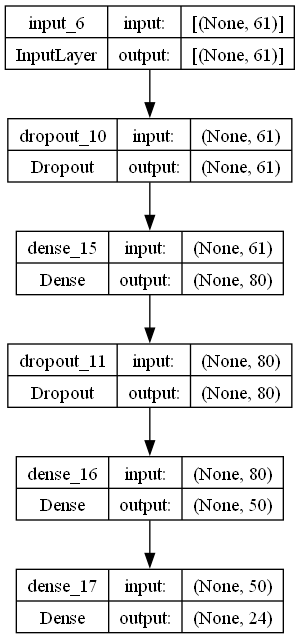

In [123]:
with open(classrep_path, 'w', newline='') as f:
    writer = csv.writer(f)
    # Write the headers
    writer.writerow(["Class", "Precision", "Recall", "F1-Score", "Support"])
    
    # Write the rows
    for key, value in classrep_dict.items():
        if isinstance(value, dict):
            writer.writerow([key, value['precision'], value['recall'], value['f1-score'], value['support']])
        else:
            writer.writerow([key, value])
        
plot_model(model, to_file=architecture_path, show_shapes=True, show_layer_names=True)

# Tensorflow-Lite

In [124]:
model.save(model_save_path, include_optimizer=False)

In [125]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ivono\AppData\Local\Temp\tmpkpxpdoxi\assets


INFO:tensorflow:Assets written to: C:\Users\ivono\AppData\Local\Temp\tmpkpxpdoxi\assets


13024

In [126]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [127]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [128]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [129]:
%%time
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 1 ms


In [130]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.69593289e-01 1.62720904e-02 1.72640495e-02 1.04253355e-03
 3.74501586e-01 8.32038000e-03 4.49727668e-05 1.00834797e-04
 2.43529484e-01 1.31286492e-04 1.40322847e-02 2.63944939e-02
 7.67231034e-03 5.91865880e-03 2.97194380e-10 5.23552224e-09
 1.79318222e-03 1.09539174e-01 6.85529494e-06 1.08299275e-04
 4.15781979e-04 1.53080514e-03 2.72254856e-05 1.76031771e-03]
4
